<a href="https://colab.research.google.com/github/rprimi/colB5BERT/blob/main/python/colB5BERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **colB5BERT:** Fine tuning colBERT with Big Five dataset

* Notebook inspirado no buscador denso de Marcos Pio

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install transformers

In [3]:
!git clone https://github.com/rprimi/colB5BERT.git

%cd /content/colB5BERT
!git pull



Cloning into 'colB5BERT'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 234 (delta 29), reused 18 (delta 18), pack-reused 196
Receiving objects: 100% (234/234), 31.76 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (144/144), done.
/content/colB5BERT
Already up to date.


### Libraries

In [4]:
import sys
sys.path.append('/content/colB5BERT/python/')

import utils
import vsm
import sst




In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
b5_data = pd.read_csv('/content/colB5BERT/data/db_textos.splitted.csv', sep=';')
b5_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11537 entries, 0 to 11536
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              11537 non-null  int64 
 1   id_divisao      11537 non-null  int64 
 2   texto_dividido  11537 non-null  object
dtypes: int64(2), object(1)
memory usage: 270.5+ KB


In [ ]:
import pandas as pd
base_itens_b5 = pd.read_excel('/content/colB5BERT/data/base_itens.xlsx')


base_itens_b5
base_itens_b5.info()
# base_itens_b5['item_pt_text'].tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ord0_index    415 non-null    int64  
 1   test          415 non-null    object 
 2   coditem       415 non-null    object 
 3   item_pt_text  415 non-null    object 
 4   item_en_text  415 non-null    object 
 5   domain        413 non-null    object 
 6   facet         413 non-null    object 
 7   pole          415 non-null    int64  
 8   seman_pairs   273 non-null    float64
dtypes: float64(1), int64(2), object(6)
memory usage: 29.3+ KB


In [ ]:
bert_weights_name = 'neuralmind/bert-base-portuguese-cased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_weights_name)
bert_model = BertModel.from_pretrained(bert_weights_name)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Introdução

Vamos treinar um buscador denso. Versão mais simples, usando dataset normal.

# Installs and imports

In [ ]:
!free -mh
!lscpu
!nvidia-smi

              total        used        free      shared  buff/cache   available
Mem:           25Gi       8.8Gi       3.1Gi       232Mi        13Gi        15Gi
Swap:            0B          0B          0B
Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          4
On-line CPU(s) list:             0-3
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cach

In [ ]:
# %%capture
# !wget -nc https://raw.githubusercontent.com/marcospiau/ia368-dd-dl4ir/main/scripts/install_anserini.sh && chmod +x install_anserini.sh && time ./install_anserini.sh

In [ ]:
%%capture
!pip install -q ftfy polars toolz cytoolz transformers datasets gcsfs sentence-transformers torchdata torcharrow
# !pip install -U t5[gcp,cache-tasks]==0.9.3
# !pip install -U jaxlib
!sudo apt install -qq tree htop

In [ ]:
!wget -nc https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
!ls -lht
!head msmarco_triples.train.tiny.tsv

--2023-04-19 18:59:14--  https://storage.googleapis.com/unicamp-dl/ia368dd_2023s1/msmarco/msmarco_triples.train.tiny.tsv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8076179 (7.7M) [text/tab-separated-values]
Saving to: ‘msmarco_triples.train.tiny.tsv’

msmarco_triples.tra 100%[===================>]   7.70M  6.35MB/s    in 1.2s    

2023-04-19 18:59:15 (6.35 MB/s) - ‘msmarco_triples.train.tiny.tsv’ saved [8076179/8076179]

total 7.8M
drwxr-xr-x 1 root root 4.0K Apr 18 22:00 sample_data
-rw-r--r-- 1 root root 7.8M Feb  6 12:05 msmarco_triples.train.tiny.tsv
is a little caffeine ok during pregnancy	We donât know a lot about the effects of caffeine during pregnancy on you and your baby. So itâs best to limit the amount you get each day. If youâre pregnant, limit caffein

In [ ]:
import os
import functools
import pandas as pd
import polars as pl
import ftfy
import toolz
import itertools
import more_itertools
from collections import Counter, defaultdict
from tqdm import tqdm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 1000)

os.environ['POLARS_FMT_STR_LEN']='1000'

import torchdata
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchdata.dataloader2 import DataLoader2
from torch.utils.data import DataLoader, Dataset

import datasets
import numpy as np

from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding
import multiprocessing as mp
import lightning as L
from etils import epath

import gc

# tree-dm, used on jax
import tree

from pathlib import Path

DEFAULT_RANDOM_SEED = 42

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s %(message)s', level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)

# Data preprocessing

## Loading and preprocessing TSV

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/MiniLM-L12-H384-uncased')

In [ ]:
def load_tsv(path):
    # load tsv
    df = (
        pl.read_csv(path, has_header=False,
                    new_columns=['query', 'passage', 'negative_passage'],
                    separator='\t'))
    df = df.drop('negative_passage')
    # fix text encoding
    df = df.select(pl.all().apply(ftfy.fix_text))
    df = df.sort(pl.all())
    return df


df = load_tsv('msmarco_triples.train.tiny.tsv')
df.head()

query,passage
str,str
""". in what kind of government does a small group have a firm control over a country? brainly""","""Q: What kind of government does a small group have a firm control over a country A: In Oligarchy government, a small group have a firm control over a country. Log in for more information."""
"""1 cup of strawberries nutrition facts""","""The facts on strawberry nutrition are impressive. There are 49 calories in one cup of strawberries. Strawberries are also loaded with Vitamin C, 3 grams of fiber, and some calcium, magnesium, and potassium. The simple fact is that the little strawberry is big on nutrition."""
"""1. what is meant by equality""","""Assignment 1.1 Explain what is meant by: Diversity, Equality and inclusion Equality means that every human being is to be treated in the same way and once cannot differentiate between people, being cause of their faith, sexuality, nationality, gender or age."""
"""Akbar Birthplace""","""Born on October 15, 1542 in Umarkot, India, and enthroned at age 14, Akbar the Great began his military conquests under the tutelage of a regent before claiming imperial power and expanding the Mughal Empire."""
"""Average speed is defined as""","""The average speed of an object is defined as the distance traveled divided by the time elapsed. Velocity is a vector quantity, and average velocity can be defined as the displacement divided by the time. For the special case of straight line motion in the x direction, the average velocity takes the form:"""


## Tokenizing data

In [ ]:
def tokenize(tokenizer, df: pl.DataFrame, **tokenizer_kwargs_by_col):
    def fn(col):
        # tokenize efficieltly using HuggingFace datasets
        ds = datasets.Dataset(df.select(col).to_arrow())
        tokenize_fn = functools.partial(
            tokenizer,
            **tokenizer_kwargs_by_col.get(col, {}))
        ds = ds.map(tokenize_fn, input_columns=[col], num_proc=mp.cpu_count())
        ds = ds.remove_columns(
            set(ds.column_names) - {'input_ids', 'attention_mask'})
        # convert back to polars datasts
        new_df = pl.from_arrow(ds.data.table)
        new_df = new_df.to_struct(col)
        return new_df

    cols = ['query', 'passage']
    # two series with structs for tokenized queries and passages
    out = list(map(fn, cols))
    # convert to dataframe
    out = pl.DataFrame(out)
    return out

df_tokens_nolimit = tokenize(tokenizer, df)
df_tokens_nolimit.head()

Map (num_proc=4):   0%|          | 0/11000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/11000 [00:00<?, ? examples/s]

query,passage
struct[2],struct[2]
"{[101, 1012, … 102],[1, 1, … 1]}","{[101, 1053, … 102],[1, 1, … 1]}"
"{[101, 1015, … 102],[1, 1, … 1]}","{[101, 1996, … 102],[1, 1, … 1]}"
"{[101, 1015, … 102],[1, 1, … 1]}","{[101, 8775, … 102],[1, 1, … 1]}"
"{[101, 20730, … 102],[1, 1, … 1]}","{[101, 2141, … 102],[1, 1, … 1]}"
"{[101, 2779, … 102],[1, 1, … 1]}","{[101, 1996, … 102],[1, 1, … 1]}"


Token lengths with no truncation:

,query,passage
count,11000.000000,11000.000000
mean,9.103636,80.646818
std,2.850582,32.416037
min,4.000000,13.000000
25%,7.000000,59.000000
50%,9.000000,72.000000
75%,10.000000,98.000000
95%,14.000000,144.000000
99%,18.000000,177.010000
max,43.000000,280.000000


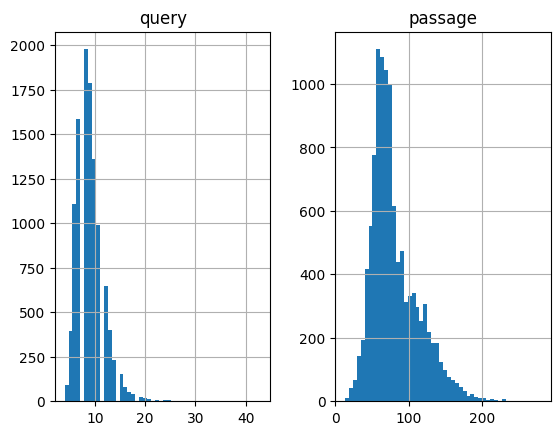

In [ ]:
def check_token_lengths(df):
    token_lengths = (
        df.select(pl.col(col).struct.field('input_ids').arr.lengths().alias(col)
        for col in ['query', 'passage']))
    token_lengths = token_lengths.to_pandas()
    display(token_lengths.describe(percentiles=[.25, .5, .75, .95, .99]))
    token_lengths.hist(bins=50)

check_token_lengths(df_tokens_nolimit)

Based on the above values, we will select **32** and **200** as maximum sequence lengths for query and passage fields, respectively.

Map (num_proc=4):   0%|          | 0/11000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Map (num_proc=4):   0%|          | 0/11000 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

,query,passage
count,11000.000000,11000.000000
mean,9.097455,80.572273
std,2.791535,32.095900
min,4.000000,13.000000
25%,7.000000,59.000000
50%,9.000000,72.000000
75%,10.000000,98.000000
95%,14.000000,144.000000
99%,18.000000,177.010000
max,32.000000,200.000000


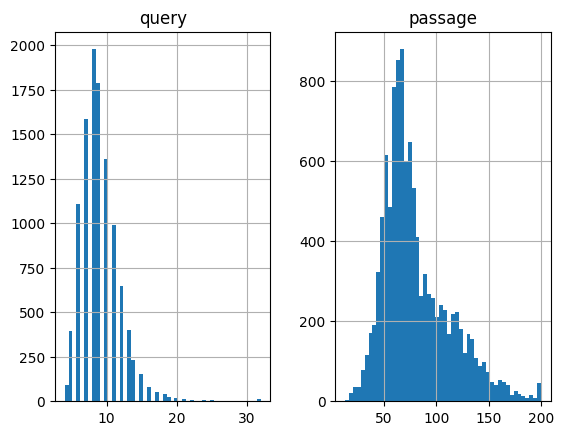

In [ ]:
df_tokens = tokenize(tokenizer, df, query={'max_length': 32}, passage={'max_length': 200})
check_token_lengths(df_tokens)

## Train/val split

We will use 10_000 examples for training and the remaining 1_000 for validation.

In [ ]:
class SimpleIndexerDataset(Dataset):
    """Dataset data simply index input data"""
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

ds_all = SimpleIndexerDataset(df_tokens.to_dicts())
ds_train, ds_val = torch.utils.data.random_split(
    ds_all,
    lengths=[10_000, 1_000],
    generator=torch.Generator().manual_seed(DEFAULT_RANDOM_SEED))

list(map(len, [ds_train, ds_val]))

[10000, 1000]

One example:

In [ ]:
ds_train[0]

## Collating examples

Because we have features with keys different from expected from HuggingFace collator, we will need to create a custom collator.

There reason for this design is to reuse HuggingFace collate functions.


In [ ]:
def prefix_dict_keys(d, prefix):
    return {f'{prefix}{k}': v for k, v in d.items()}

def query_passage_collator(collate_fn, batch):
    """Collate 'query' and 'passage' contents separately using two DataCollatorWithPadding"""
    def fn(items):
        # dict to accumulate by key
        d = defaultdict(list)
        for item in items:
            for key, value in item.items():
                d[key].append(value)
        d.default_factory = None
        d = collate_fn(d)
        # d = prefix_dict_keys(d, query_or_passage + '_')
        return d

    out = {}
    for query_or_passage in ['query', 'passage']:
        out[query_or_passage] = fn([item[query_or_passage] for item in batch])
    return out

collate_fn = functools.partial(query_passage_collator,
                               DataCollatorWithPadding(tokenizer=tokenizer))

In [ ]:
debug_dataloader = DataLoader(ds_train, shuffle=False, collate_fn=collate_fn, batch_size=8)

In [ ]:
for debug_batch in itertools.islice(debug_dataloader, 20):
    print('shapes: ', tree.map_structure(lambda x: x.shape, debug_batch))
    # print('batch:', batch)


shapes:  {'query': {'input_ids': torch.Size([8, 12]), 'attention_mask': torch.Size([8, 12])}, 'passage': {'input_ids': torch.Size([8, 159]), 'attention_mask': torch.Size([8, 159])}}
shapes:  {'query': {'input_ids': torch.Size([8, 11]), 'attention_mask': torch.Size([8, 11])}, 'passage': {'input_ids': torch.Size([8, 113]), 'attention_mask': torch.Size([8, 113])}}
shapes:  {'query': {'input_ids': torch.Size([8, 11]), 'attention_mask': torch.Size([8, 11])}, 'passage': {'input_ids': torch.Size([8, 112]), 'attention_mask': torch.Size([8, 112])}}
shapes:  {'query': {'input_ids': torch.Size([8, 13]), 'attention_mask': torch.Size([8, 13])}, 'passage': {'input_ids': torch.Size([8, 134]), 'attention_mask': torch.Size([8, 134])}}
shapes:  {'query': {'input_ids': torch.Size([8, 14]), 'attention_mask': torch.Size([8, 14])}, 'passage': {'input_ids': torch.Size([8, 105]), 'attention_mask': torch.Size([8, 105])}}
shapes:  {'query': {'input_ids': torch.Size([8, 11]), 'attention_mask': torch.Size([8, 11]

# Modeling

Mean pooling aggregates token embeddings into a single embedding that summarizes the entire sentence. To avoid bias towards longer or shorter sentences, it's crucial to exclude padding tokens from the calculation since they don't contribute to the sentence's meaning.

In [ ]:
from torch import Tensor as T

# https://github.com/UKPLab/sentence-transformers/tree/master/examples/applications/computing-embeddings
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

# https://github.com/facebookresearch/DPR/blob/main/dpr/models/biencoder.py
def dot_product_scores(q_vectors: T, ctx_vectors: T) -> T:
    """
    calculates q->ctx scores for every row in ctx_vector
    :param q_vector:
    :param ctx_vector:
    :return:
    """
    # q_vector: n1 x D, ctx_vectors: n2 x D, result n1 x n2
    r = torch.matmul(q_vectors, torch.transpose(ctx_vectors, 0, 1))
    return r

# https://github.com/facebookresearch/DPR/blob/main/dpr/models/biencoder.py#L254
def biencoder_nll_loss(scores):
    """Loss that uses in-batch hard negatives:="""
    softmax_scores = F.log_softmax(scores, dim=1)
    positive_idx_per_question = torch.arange(scores.size(0),
                                             device=scores.device)
    loss = F.nll_loss(softmax_scores, positive_idx_per_question,
                      reduction='mean')

    max_score, max_idxs = torch.max(softmax_scores, 1)
    correct_predictions_count = (max_idxs == positive_idx_per_question).sum()

    return loss, correct_predictions_count.detach().item()

def encode(encoder, input_ids, attention_mask):
    """Compute sentence embeddings using a mean pooling"""
    model_output = encoder(input_ids=input_ids, attention_mask=attention_mask)
    pooled = mean_pooling(model_output, attention_mask)
    return pooled

## visual inspection of each step

In [ ]:
debug_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')

Encoding a test batch of queries and passages:

In [ ]:
debug_query_embeddings = encode(
    debug_encoder,
    **debug_batch['query']
)
debug_query_embeddings.shape

torch.Size([8, 384])

In [ ]:
debug_passage_embeddings = encode(
    debug_encoder,
    **debug_batch['passage']
)
debug_passage_embeddings.shape

torch.Size([8, 384])

Computing dot-product scores:

In [ ]:
debug_scores = dot_product_scores(debug_query_embeddings,
                                  debug_passage_embeddings)

In [ ]:
dot_product_scores(debug_query_embeddings, debug_passage_embeddings)

tensor([[26.4448, 24.9978, 24.5690, 23.6798, 22.2136, 26.6341, 24.5998, 25.7518],
        [26.6808, 32.9043, 27.5247, 27.9297, 28.2326, 31.5018, 30.7444, 27.7581],
        [29.1752, 30.5720, 32.3448, 28.0939, 27.6652, 30.1963, 30.4538, 28.6949],
        [26.8096, 27.9580, 26.4391, 29.3355, 24.8865, 28.4798, 28.1296, 28.0977],
        [25.7406, 28.7956, 26.3448, 26.7510, 27.5839, 29.3751, 28.7996, 27.8512],
        [25.1585, 26.8746, 23.2677, 24.6058, 23.6406, 29.2818, 25.4393, 26.2495],
        [23.5991, 27.2904, 23.7127, 24.8648, 24.4227, 28.1350, 26.5412, 25.2567],
        [23.2814, 21.4098, 20.5989, 22.2167, 19.9083, 23.8001, 22.1562, 24.0090]],
       grad_fn=<MmBackward0>)

Unstrained models doesn't have scores concentrated on diagonal:

In [ ]:
dot_product_scores(debug_passage_embeddings, debug_passage_embeddings).softmax(-1).mul(100).to(torch.long)

tensor([[64,  3,  4,  3,  0,  7,  7,  8],
        [ 0, 86,  0,  0,  0,  4,  7,  0],
        [ 0,  2, 86,  1,  0,  0,  7,  0],
        [ 0,  5,  1, 69,  1,  2, 18,  1],
        [ 0, 18,  1,  2, 25,  3, 48,  0],
        [ 0, 30,  0,  0,  0, 60,  6,  0],
        [ 0,  3,  0,  0,  0,  0, 94,  0],
        [ 9,  6,  3, 10,  2, 10, 12, 44]])

In [ ]:
dot_product_scores(debug_passage_embeddings, debug_passage_embeddings)

tensor([[64,  3,  4,  3,  0,  7,  7,  8],
        [ 0, 86,  0,  0,  0,  4,  7,  0],
        [ 0,  2, 86,  1,  0,  0,  7,  0],
        [ 0,  5,  1, 69,  1,  2, 18,  1],
        [ 0, 18,  1,  2, 25,  3, 48,  0],
        [ 0, 30,  0,  0,  0, 60,  6,  0],
        [ 0,  3,  0,  0,  0,  0, 94,  0],
        [ 9,  6,  3, 10,  2, 10, 12, 44]])

## One batch overfit

In [ ]:
class DPR(nn.Module):
    def __init__(self, query_encoder, passage_encoder):
        super().__init__()
        self.query_encoder = query_encoder
        self.passage_encoder = passage_encoder

In [ ]:
def train_step(fabric, model, optimizer, batch):
    optimizer.zero_grad(set_to_none=True)
    query_embeddings = encode(model.query_encoder, **batch['query'])
    passage_embeddings = encode(model.passage_encoder, **batch['passage'])

    scores = dot_product_scores(query_embeddings, passage_embeddings)
    loss, correct_predictions_count = biencoder_nll_loss(scores)
    fabric.backward(loss)
    optimizer.step()
    loss = loss.detach().item()
    correct_pct = correct_predictions_count / batch['query'].input_ids.size(0)
    return {'train_loss': loss,
            'train_correct_count': correct_predictions_count,
            'train_correct_pct': correct_pct}

@torch.no_grad()
def eval_loop(fabric, model, dataloader):
    fabric.print('Running validation loop')
    model.eval()
    running_totals = defaultdict(int)
    for n, batch in enumerate(dataloader, 1):
        query_embeddings = encode(model.query_encoder, **batch['query'])
        passage_embeddings = encode(model.passage_encoder, **batch['passage'])
        scores = dot_product_scores(query_embeddings, passage_embeddings)
        loss, correct_predictions_count = biencoder_nll_loss(scores)

        running_totals['eval_loss'] += loss.detach().item()
        running_totals['eval_correct_predictions_count'] += correct_predictions_count
        running_totals['eval_correct_pct'] += (
            correct_predictions_count / batch['query'].input_ids.size(0))


    running_totals = dict(running_totals)
    correct_pct = correct_predictions_count / batch['query'].input_ids.size(0)
    out = tree.map_structure(lambda x: x / n, running_totals)
    model.train()
    return out

In [ ]:
TRAIN_BATCH_SIZE = 64
train_loader = DataLoader(torch.utils.data.Subset(ds_train, range(TRAIN_BATCH_SIZE)),
                          shuffle=False, collate_fn=collate_fn, batch_size=TRAIN_BATCH_SIZE)
val_loader = train_loader


fabric = L.Fabric(precision='16-mixed', accelerator='cuda',
                  loggers=L.fabric.loggers.CSVLogger(root_dir='logs1',
                                                     flush_logs_every_n_steps=1,
                                                     version=1))

fabric.launch()

# Siamese network, using same encoder for both queries and passages
query_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
passage_encoder = query_encoder


model = DPR(query_encoder, passage_encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, optimizer = fabric.setup(model, optimizer)
train_loader, val_loader = fabric.setup_dataloaders(train_loader, val_loader)

for n in range(20):
    for batch in train_loader:
        print(train_step(fabric, model, optimizer, batch))


print('eval metrics:', eval_loop(fabric, model, val_loader))

INFO: Using 16-bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16-bit Automatic Mixed Precision (AMP)


{'train_loss': 7.0375590324401855, 'train_correct_count': 3, 'train_correct_pct': 0.046875}
{'train_loss': 2.9686756134033203, 'train_correct_count': 16, 'train_correct_pct': 0.25}
{'train_loss': 2.0920310020446777, 'train_correct_count': 38, 'train_correct_pct': 0.59375}
{'train_loss': 1.4908446073532104, 'train_correct_count': 45, 'train_correct_pct': 0.703125}
{'train_loss': 0.947971761226654, 'train_correct_count': 54, 'train_correct_pct': 0.84375}
{'train_loss': 0.5517137050628662, 'train_correct_count': 59, 'train_correct_pct': 0.921875}
{'train_loss': 0.279044508934021, 'train_correct_count': 64, 'train_correct_pct': 1.0}
{'train_loss': 0.13904553651809692, 'train_correct_count': 64, 'train_correct_pct': 1.0}
{'train_loss': 0.07714009284973145, 'train_correct_count': 64, 'train_correct_pct': 1.0}
{'train_loss': 0.04148540645837784, 'train_correct_count': 64, 'train_correct_pct': 1.0}
{'train_loss': 0.020867642015218735, 'train_correct_count': 64, 'train_correct_pct': 1.0}
{'trai

In [ ]:
del val_loader, train_loader, fabric, query_encoder, passage_encoder
torch.cuda.empty_cache()
gc.collect()

33

OK, we can overfit a single batch.

## Single encoder for queries and passages

In [ ]:
def get_checkpoint_dir(basedir, global_step):
    return Path(basedir) / f'ckpt-{global_step}/'

def save_checkpoint(basedir, model, optimizer, global_step):
    names_and_obj = [
        ('model', model.state_dict()),
        ('optimizer', optimizer.state_dict()),
        ('global_step', global_step),
    ]
    basedir = Path(basedir)
    basedir.parent.mkdir(parents=True, exist_ok=True)
    ckpt_file = basedir / f'ckpt-{global_step}.pt'
    logging.info('Saving checkpoint to %s', ckpt_file)
    torch.save(dict(names_and_obj), ckpt_file)


In [ ]:
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = TRAIN_BATCH_SIZE
output_dir = Path('single_encoder')
NUM_EPOCHS = 10
STEPS_PER_EPOCH = len(ds_train) // TRAIN_BATCH_SIZE
TRAIN_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS
eval_steps_interval = STEPS_PER_EPOCH
save_steps_interval = STEPS_PER_EPOCH


train_loader = DataLoader(ds_train,
                          shuffle=True, collate_fn=collate_fn,
                          batch_size=TRAIN_BATCH_SIZE)
val_loader = DataLoader(ds_val,
                        shuffle=False, collate_fn=collate_fn,
                        batch_size=EVAL_BATCH_SIZE)

loggers = [
    L.fabric.loggers.CSVLogger(root_dir=output_dir),
    # L.fabric.loggers.TensorBoardLogger(root_dir=output_dir / 'logs',
    #                                     flush_logs_every_n_steps=1)
]
fabric = L.Fabric(precision='16-mixed', accelerator='cuda', loggers=loggers)
fabric.launch()


# Siamese network, using same encoder for both queries and passages
query_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
passage_encoder = query_encoder


model = DPR(query_encoder, passage_encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, optimizer = fabric.setup(model, optimizer)
train_loader, val_loader = fabric.setup_dataloaders(train_loader, val_loader)


global_step = 0
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_loader, total=STEPS_PER_EPOCH - 1,
                      desc=f'Training epoch {epoch}'):
        train_metrics = train_step(fabric, model, optimizer, batch)
        fabric.log_dict(train_metrics, step=global_step)
        global_step += 1

        if global_step % eval_steps_interval == 0:
            eval_metrics = eval_loop(fabric, model, val_loader)
            fabric.log_dict(eval_metrics)
            print(f'eval_metrics epoch epoch={epoch}, global_step={global_step}',
                  eval_metrics)

        if global_step % save_steps_interval == 0:
            save_checkpoint(output_dir, model, optimizer, global_step)

    fabric.logger.finalize('SUCCESS')

INFO: Using 16-bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16-bit Automatic Mixed Precision (AMP)
Training epoch 0:   0%|          | 0/155 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory single_encoder/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
Training epoch 0: 100%|██████████| 155/155 [01:38<00:00,  1.52it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-156.pt


eval_metrics epoch epoch=0, global_step=156 {'eval_loss': 0.11799028841778636, 'eval_correct_predictions_count': 60.375, 'eval_correct_pct': 0.9662109375}


Training epoch 0: 157it [01:44,  1.51it/s]
Training epoch 1:  99%|█████████▉| 154/155 [01:41<00:00,  1.49it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-312.pt


eval_metrics epoch epoch=1, global_step=312 {'eval_loss': 0.09554271114757285, 'eval_correct_predictions_count': 61.0, 'eval_correct_pct': 0.9759765625}


Training epoch 1: 157it [01:47,  1.46it/s]
Training epoch 2:  99%|█████████▊| 153/155 [01:40<00:01,  1.49it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-468.pt


eval_metrics epoch epoch=2, global_step=468 {'eval_loss': 0.10042134299874306, 'eval_correct_predictions_count': 60.8125, 'eval_correct_pct': 0.973046875}


Training epoch 2: 157it [01:47,  1.46it/s]
Training epoch 3:  98%|█████████▊| 152/155 [01:40<00:01,  1.64it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-624.pt


eval_metrics epoch epoch=3, global_step=624 {'eval_loss': 0.1089144223369658, 'eval_correct_predictions_count': 60.3125, 'eval_correct_pct': 0.9658203125}


Training epoch 3: 157it [01:47,  1.46it/s]
Training epoch 4:  97%|█████████▋| 151/155 [01:38<00:02,  1.42it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-780.pt


eval_metrics epoch epoch=4, global_step=780 {'eval_loss': 0.122543694160413, 'eval_correct_predictions_count': 60.5, 'eval_correct_pct': 0.9681640625}


Training epoch 4: 157it [01:46,  1.48it/s]
Training epoch 5:  97%|█████████▋| 150/155 [01:38<00:03,  1.41it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-936.pt


eval_metrics epoch epoch=5, global_step=936 {'eval_loss': 0.15205801709089428, 'eval_correct_predictions_count': 60.625, 'eval_correct_pct': 0.9701171875}


Training epoch 5: 157it [01:46,  1.47it/s]
Training epoch 6:  96%|█████████▌| 149/155 [01:38<00:04,  1.38it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-1092.pt


eval_metrics epoch epoch=6, global_step=1092 {'eval_loss': 0.13092099071945995, 'eval_correct_predictions_count': 60.3125, 'eval_correct_pct': 0.965234375}


Training epoch 6: 157it [01:47,  1.46it/s]
Training epoch 7:  95%|█████████▌| 148/155 [01:37<00:04,  1.58it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-1248.pt


eval_metrics epoch epoch=7, global_step=1248 {'eval_loss': 0.13164504236192442, 'eval_correct_predictions_count': 60.375, 'eval_correct_pct': 0.966796875}


Training epoch 7: 157it [01:47,  1.46it/s]
Training epoch 8:  95%|█████████▍| 147/155 [01:37<00:05,  1.53it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-1404.pt


eval_metrics epoch epoch=8, global_step=1404 {'eval_loss': 0.13140594528522342, 'eval_correct_predictions_count': 60.4375, 'eval_correct_pct': 0.9666015625}


Training epoch 8: 157it [01:47,  1.46it/s]
Training epoch 9:  94%|█████████▍| 146/155 [01:36<00:05,  1.55it/s]

Running validation loop


INFO:root:Saving checkpoint to single_encoder/ckpt-1560.pt


eval_metrics epoch epoch=9, global_step=1560 {'eval_loss': 0.13128194166347384, 'eval_correct_predictions_count': 60.25, 'eval_correct_pct': 0.963671875}


Training epoch 9: 157it [01:47,  1.47it/s]


In [ ]:
del val_loader, train_loader, fabric, query_encoder, passage_encoder
torch.cuda.empty_cache()
gc.collect()

4798

## Different encoders for queries and passages

In [ ]:
TRAIN_BATCH_SIZE = 64
EVAL_BATCH_SIZE = TRAIN_BATCH_SIZE
output_dir = Path('two_encoder')
NUM_EPOCHS = 10
STEPS_PER_EPOCH = len(ds_train) // TRAIN_BATCH_SIZE
TRAIN_STEPS = STEPS_PER_EPOCH * NUM_EPOCHS
eval_steps_interval = STEPS_PER_EPOCH
save_steps_interval = STEPS_PER_EPOCH


train_loader = DataLoader(ds_train,
                          shuffle=True, collate_fn=collate_fn,
                          batch_size=TRAIN_BATCH_SIZE)
val_loader = DataLoader(ds_val,
                        shuffle=False, collate_fn=collate_fn,
                        batch_size=EVAL_BATCH_SIZE)

loggers = [
    L.fabric.loggers.CSVLogger(root_dir=output_dir),
    # L.fabric.loggers.TensorBoardLogger(root_dir=output_dir / 'logs',
    #                                     flush_logs_every_n_steps=1)
]
fabric = L.Fabric(precision='16-mixed', accelerator='cuda', loggers=loggers)
fabric.launch()


# separate encoders for queries and passages
query_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')
passage_encoder = AutoModel.from_pretrained('microsoft/MiniLM-L12-H384-uncased')


model = DPR(query_encoder, passage_encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model, optimizer = fabric.setup(model, optimizer)
train_loader, val_loader = fabric.setup_dataloaders(train_loader, val_loader)


global_step = 0
for epoch in range(NUM_EPOCHS):
    for batch in tqdm(train_loader, total=STEPS_PER_EPOCH - 1,
                      desc=f'Training epoch {epoch}'):
        train_metrics = train_step(fabric, model, optimizer, batch)
        fabric.log_dict(train_metrics, step=global_step)
        global_step += 1

        if global_step % eval_steps_interval == 0:
            eval_metrics = eval_loop(fabric, model, val_loader)
            fabric.log_dict(eval_metrics)
            print(f'eval_metrics epoch epoch={epoch}, global_step={global_step}',
                  eval_metrics)

        if global_step % save_steps_interval == 0:
            save_checkpoint(output_dir, model, optimizer, global_step)

    fabric.logger.finalize('SUCCESS')

INFO: Using 16-bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16-bit Automatic Mixed Precision (AMP)
Training epoch 0: 100%|██████████| 155/155 [01:38<00:00,  1.53it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-156.pt


eval_metrics epoch epoch=0, global_step=156 {'eval_loss': 0.16327804047614336, 'eval_correct_predictions_count': 59.8125, 'eval_correct_pct': 0.957421875}


Training epoch 0: 157it [01:45,  1.49it/s]
Training epoch 1:  99%|█████████▉| 154/155 [01:43<00:00,  1.55it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-312.pt


eval_metrics epoch epoch=1, global_step=312 {'eval_loss': 0.15154374856501818, 'eval_correct_predictions_count': 59.75, 'eval_correct_pct': 0.9564453125}


Training epoch 1: 157it [01:50,  1.43it/s]
Training epoch 2:  99%|█████████▊| 153/155 [01:42<00:01,  1.54it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-468.pt


eval_metrics epoch epoch=2, global_step=468 {'eval_loss': 0.16881127492524683, 'eval_correct_predictions_count': 59.3125, 'eval_correct_pct': 0.949609375}


Training epoch 2: 157it [01:50,  1.42it/s]
Training epoch 3:  98%|█████████▊| 152/155 [01:42<00:02,  1.41it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-624.pt


eval_metrics epoch epoch=3, global_step=624 {'eval_loss': 0.17697142472025007, 'eval_correct_predictions_count': 59.625, 'eval_correct_pct': 0.9544921875}


Training epoch 3: 157it [01:50,  1.41it/s]
Training epoch 4:  97%|█████████▋| 151/155 [01:41<00:02,  1.52it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-780.pt


eval_metrics epoch epoch=4, global_step=780 {'eval_loss': 0.17448980070184916, 'eval_correct_predictions_count': 59.3125, 'eval_correct_pct': 0.9490234375}


Training epoch 4: 157it [01:50,  1.43it/s]
Training epoch 5:  97%|█████████▋| 150/155 [01:41<00:03,  1.39it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-936.pt


eval_metrics epoch epoch=5, global_step=936 {'eval_loss': 0.1844855494564399, 'eval_correct_predictions_count': 59.625, 'eval_correct_pct': 0.95390625}


Training epoch 5: 157it [01:51,  1.41it/s]
Training epoch 6:  96%|█████████▌| 149/155 [01:40<00:04,  1.37it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-1092.pt


eval_metrics epoch epoch=6, global_step=1092 {'eval_loss': 0.21781652187928557, 'eval_correct_predictions_count': 59.0625, 'eval_correct_pct': 0.9451171875}


Training epoch 6: 157it [01:51,  1.41it/s]
Training epoch 7:  95%|█████████▌| 148/155 [01:38<00:04,  1.50it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-1248.pt


eval_metrics epoch epoch=7, global_step=1248 {'eval_loss': 0.1695630985777825, 'eval_correct_predictions_count': 59.5, 'eval_correct_pct': 0.9513671875}


Training epoch 7: 157it [01:49,  1.43it/s]
Training epoch 8:  95%|█████████▍| 147/155 [01:39<00:05,  1.51it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-1404.pt


eval_metrics epoch epoch=8, global_step=1404 {'eval_loss': 0.1979042700259015, 'eval_correct_predictions_count': 58.9375, 'eval_correct_pct': 0.9431640625}


Training epoch 8: 157it [01:51,  1.41it/s]
Training epoch 9:  94%|█████████▍| 146/155 [01:38<00:05,  1.55it/s]

Running validation loop


INFO:root:Saving checkpoint to two_encoder/ckpt-1560.pt


eval_metrics epoch epoch=9, global_step=1560 {'eval_loss': 0.1502116248011589, 'eval_correct_predictions_count': 59.4375, 'eval_correct_pct': 0.9509765625}


Training epoch 9: 157it [01:51,  1.41it/s]


## Backing up models to HuggigFace Hub

In [ ]:
from huggingface_hub import HfApi
from huggingface_hub import notebook_login
import huggingface_hub

HF_REPO = 'marcospiau/aula06-dense-retriever'
# Uses the HF's API to upload the model to the repo
# COPIEI DO THIAGO LAITZ

# Login to my account using the access token
# notebook_login()

hf_api = HfApi()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!ls -lht

total 7.8M
drwxr-xr-x 3 root root 4.0K Apr 20 01:55 two_encoder
drwxr-xr-x 4 root root 4.0K Apr 20 01:35 single_encoder
drwxr-xr-x 3 root root 4.0K Apr 19 22:58 logs1
drwxr-xr-x 1 root root 4.0K Apr 18 22:00 sample_data
-rw-r--r-- 1 root root 7.8M Feb  6 12:05 msmarco_triples.train.tiny.tsv


In [ ]:
hf_api.upload_folder(
    folder_path='single_encoder',
    repo_id=HF_REPO,
    path_in_repo='models/single_encoder'
)

In [ ]:
hf_api.upload_folder(
    folder_path='two_encoder',
    repo_id=HF_REPO,
    path_in_repo='models/two_encoder'
)

## Selecting best models

In [ ]:
!find | grep csv | grep log

./two_encoder/lightning_logs/version_0/metrics.csv
./single_encoder/lightning_logs/version_0/metrics.csv


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:
df_res_1.train_loss.idxmin()

784

col = train_loss


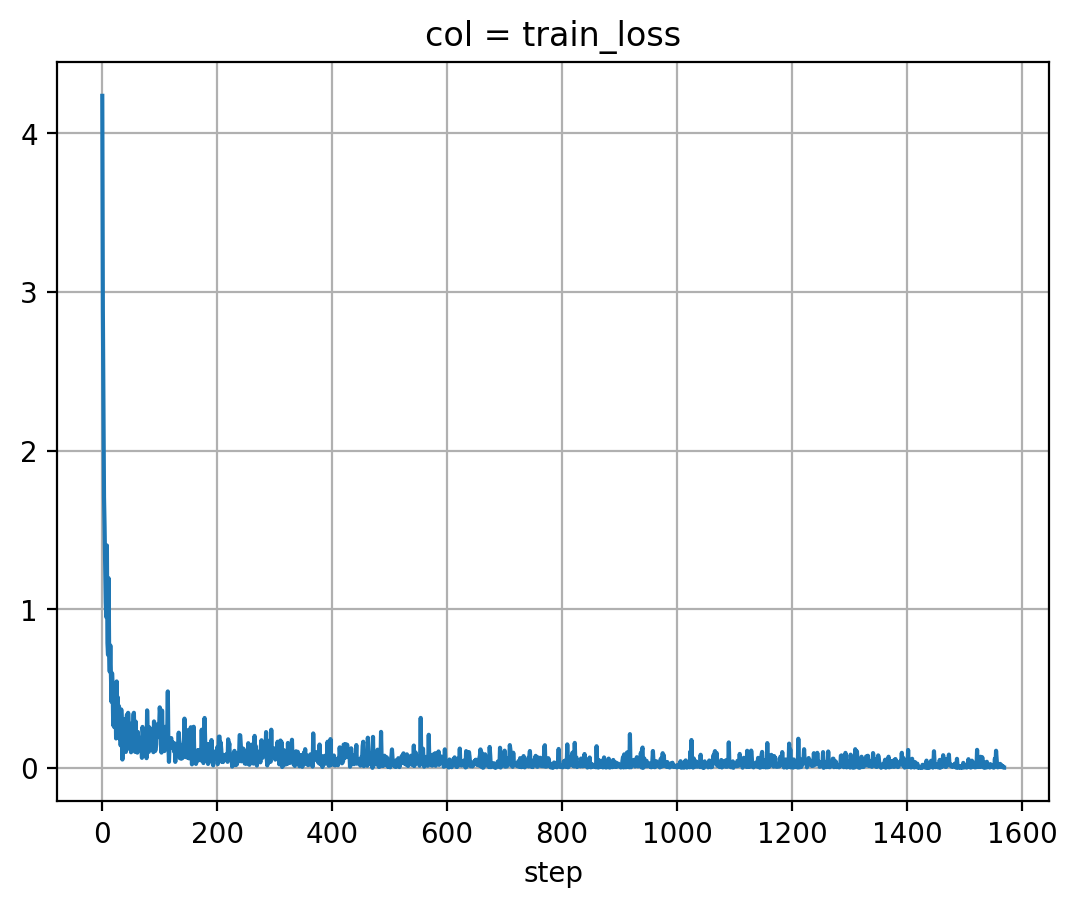

col = train_correct_count


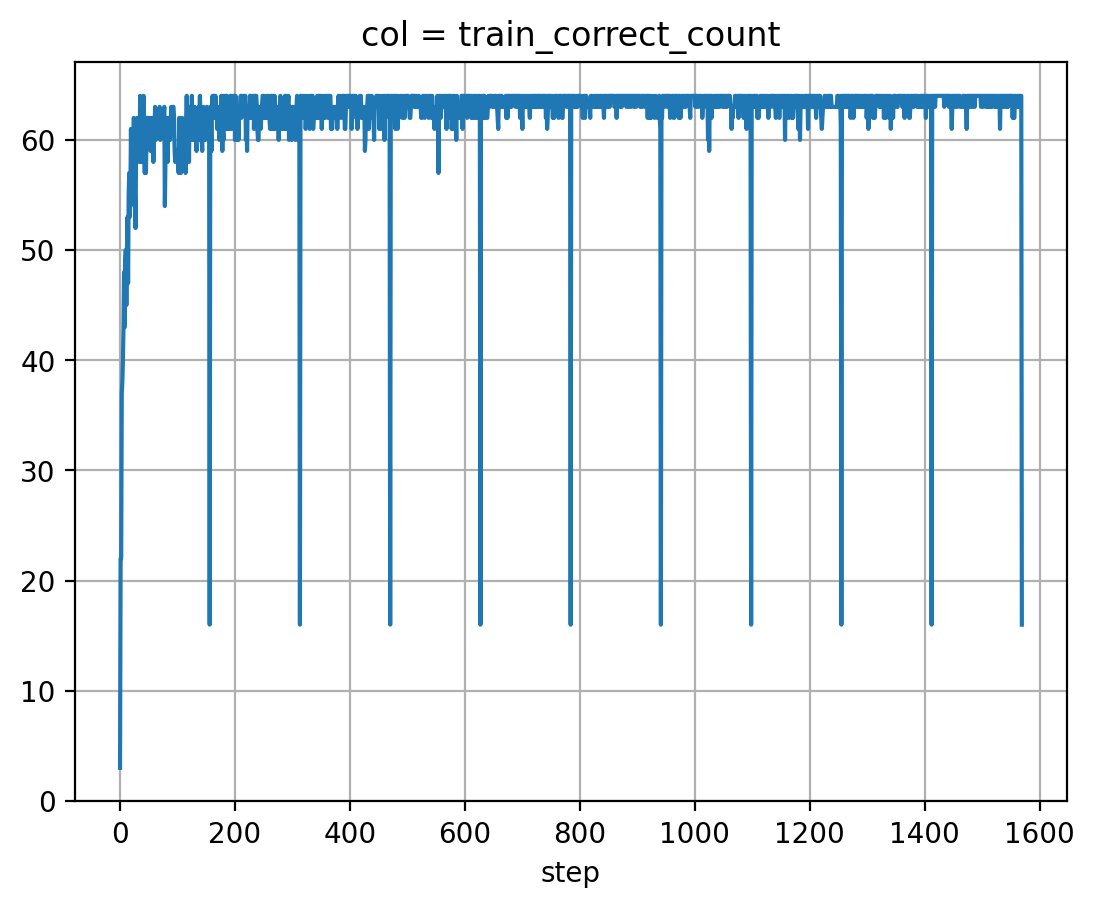

col = train_correct_pct


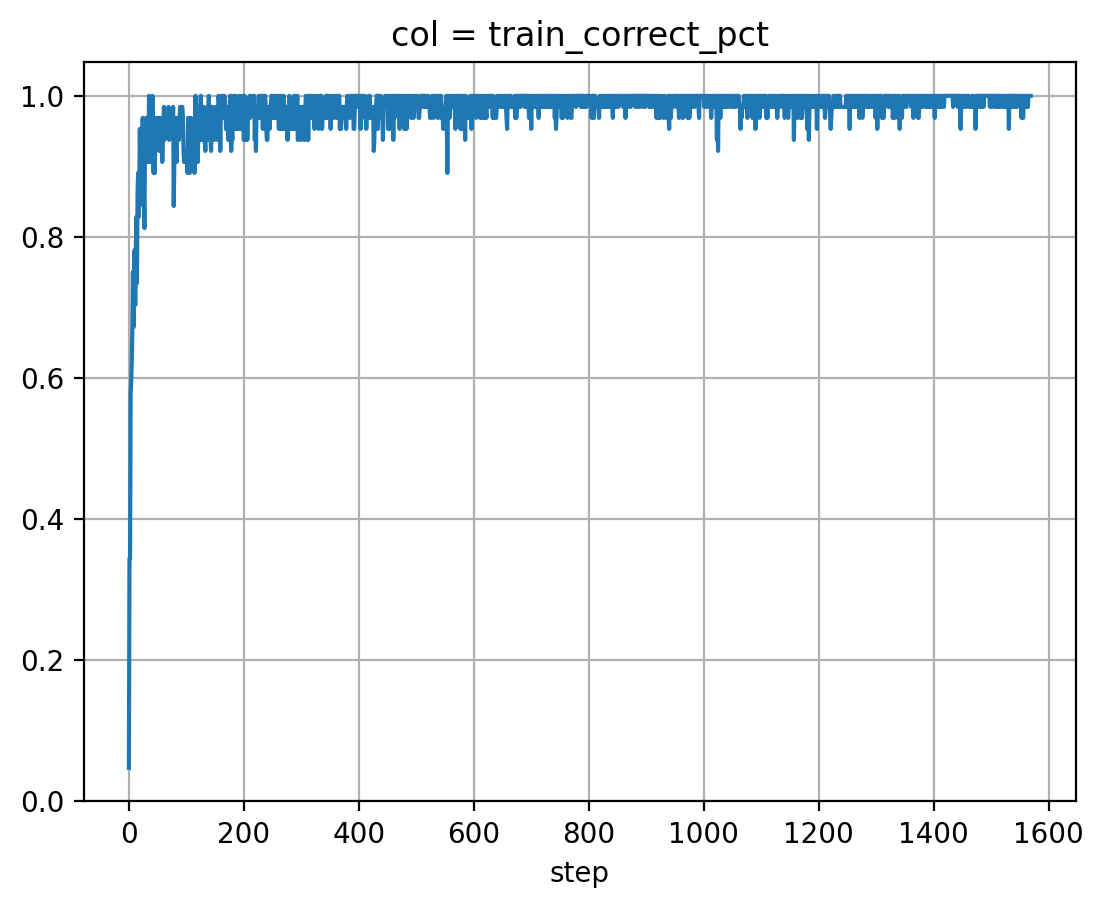

col = eval_loss


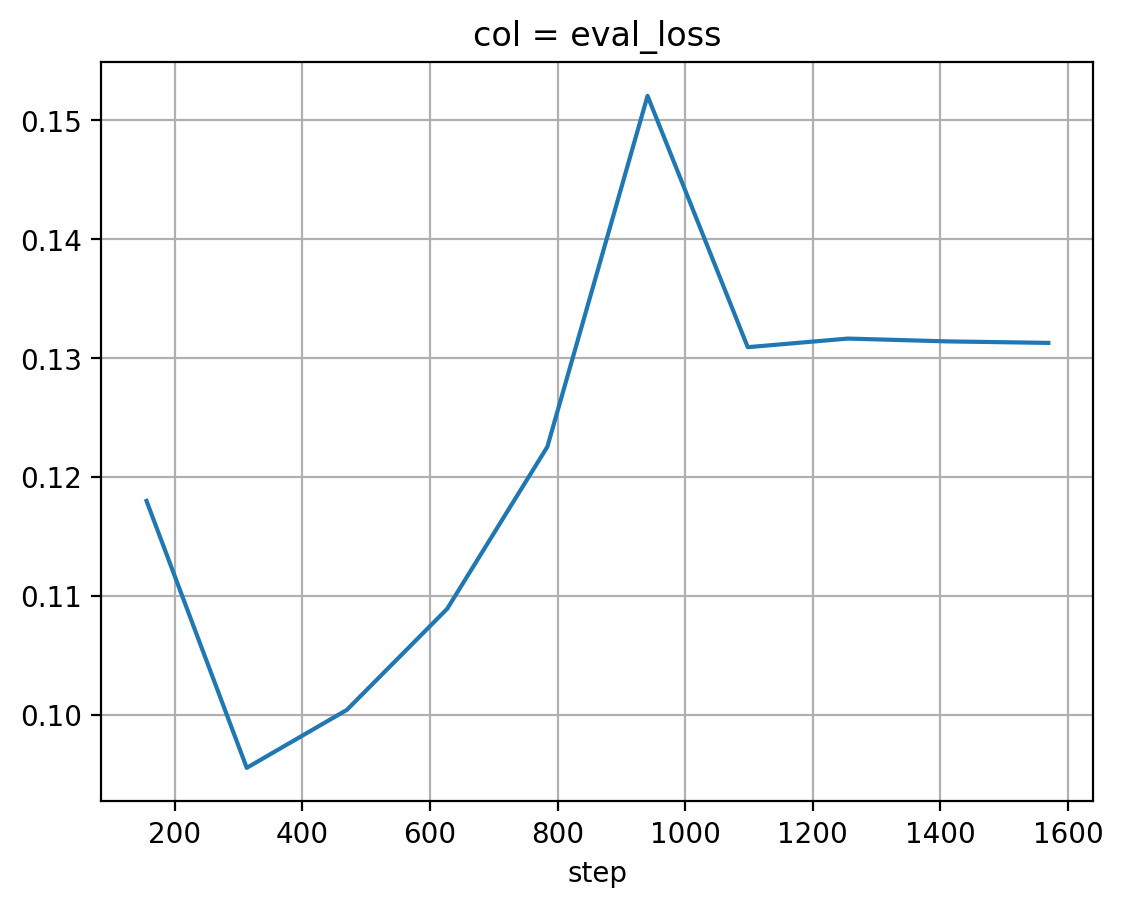

col = eval_correct_predictions_count


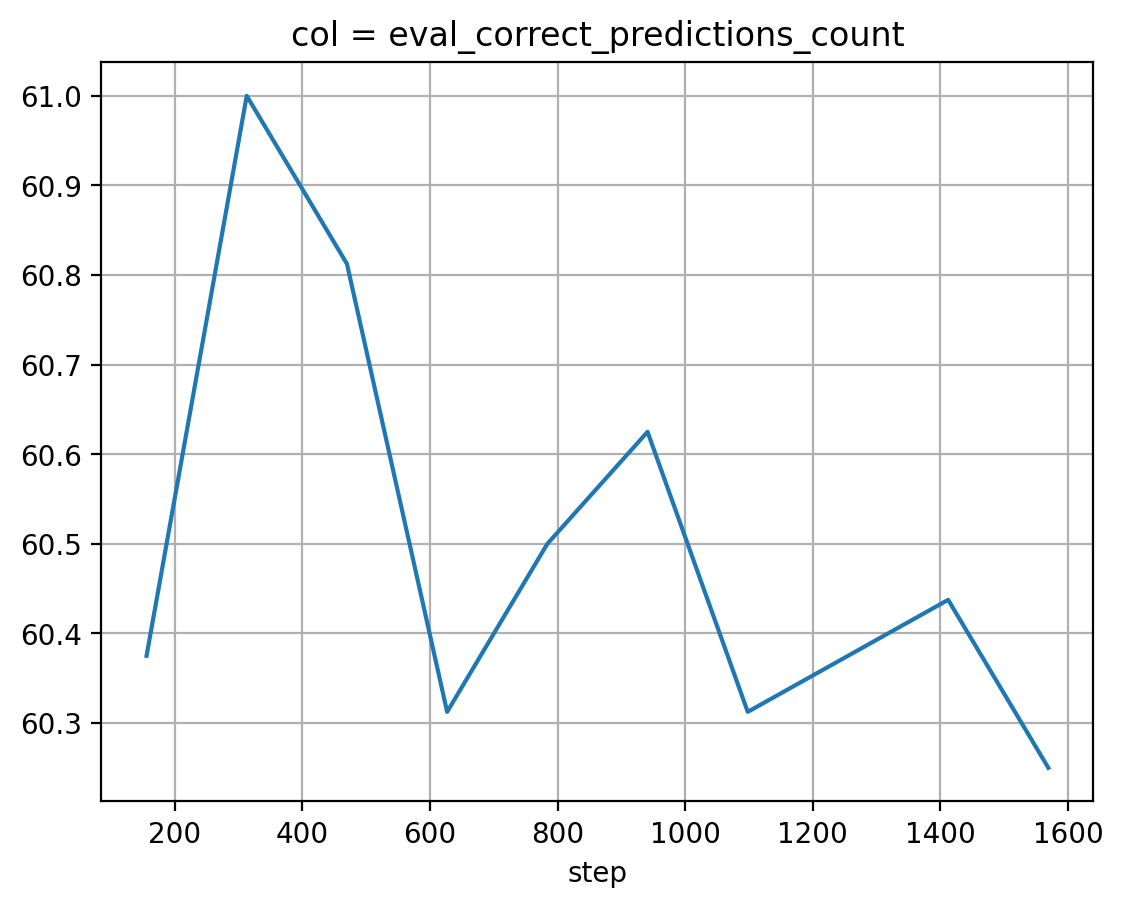

col = eval_correct_pct


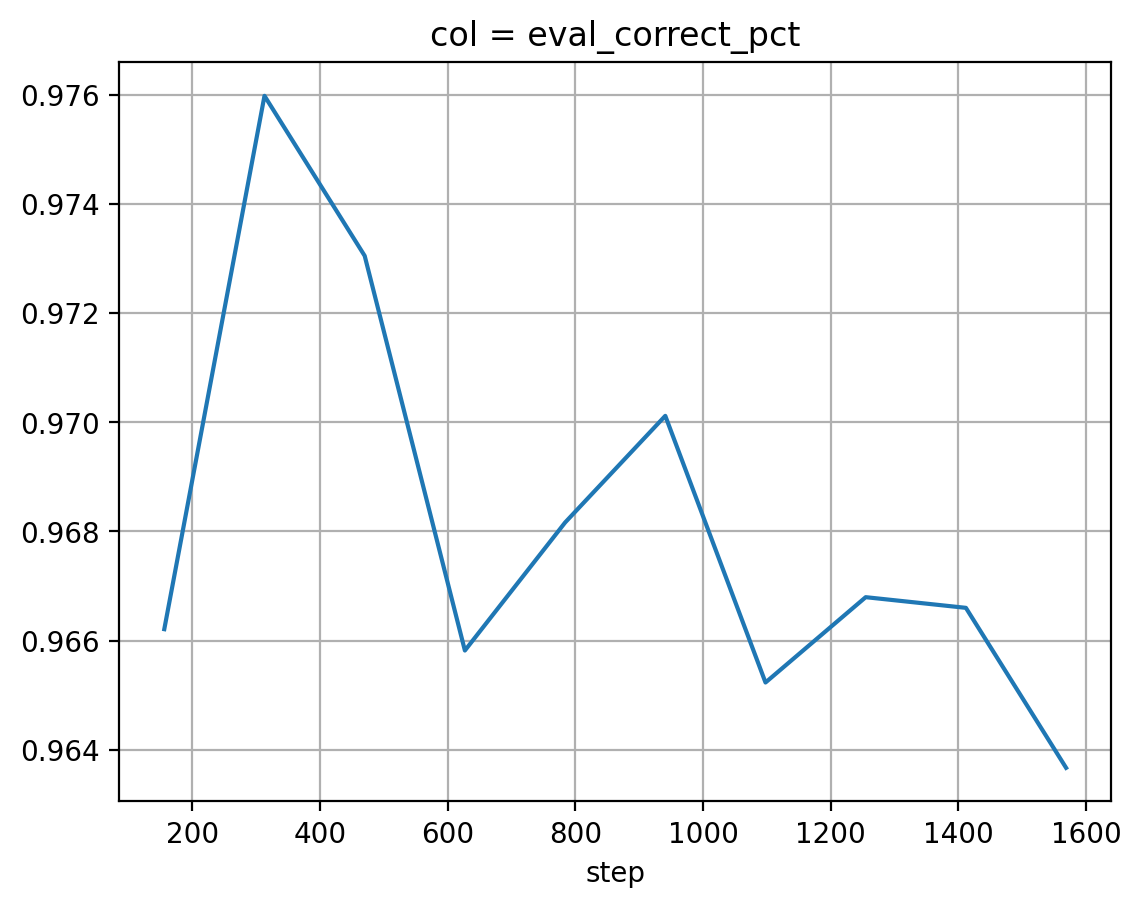

In [ ]:
def load_results(path):
    df = pd.read_csv(path).set_index('step')
    for col in df.columns:
        print(f'col = {col}')
        df_col = df[col].dropna()
        df_col.plot(title=f'col = {col}', grid=True)
        steps = df_col.index
        # step_min = steps[df_col.idxmin()]
        # step_max = steps[df_col.idxmax()]
        # maxmin = steps[[step_min, step_max]]
        # print('maxmin step = ', maxmin)

        plt.show()

    return df


df_res_1 = load_results('./single_encoder/lightning_logs/version_0/metrics.csv')


col = train_loss


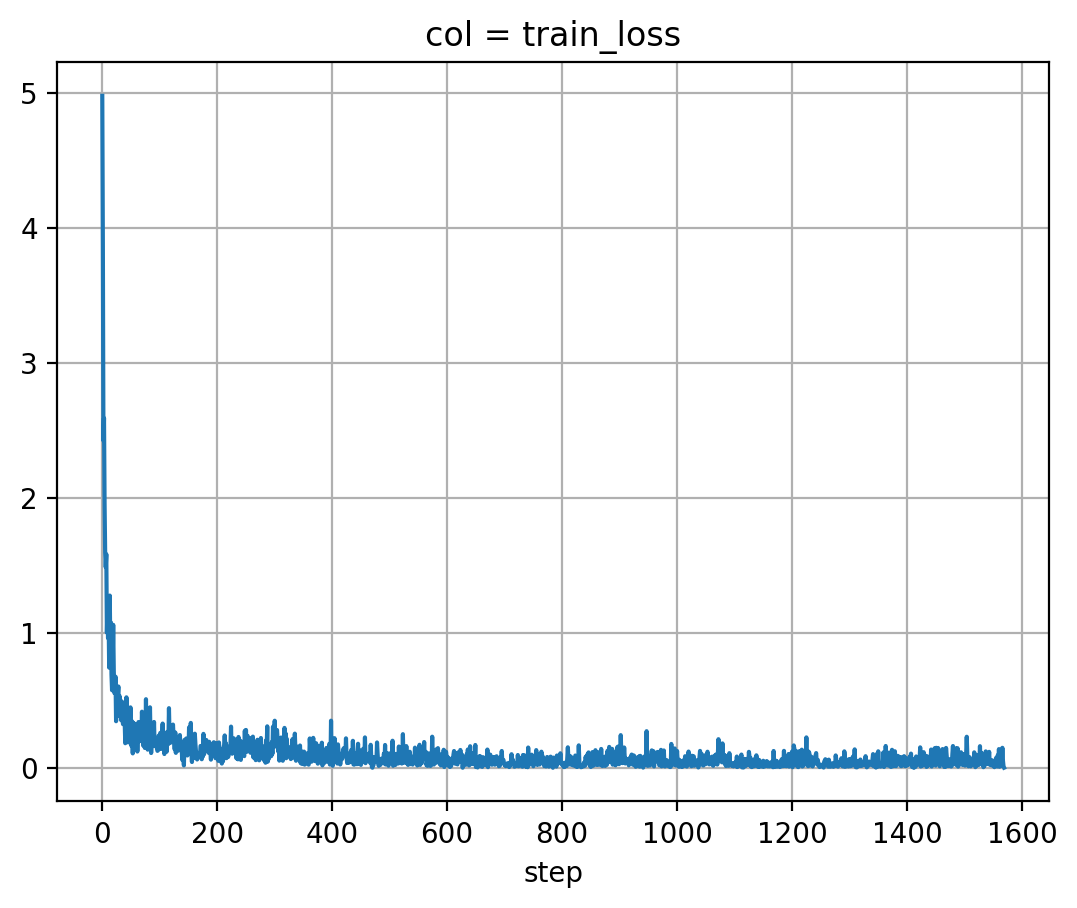

col = train_correct_count


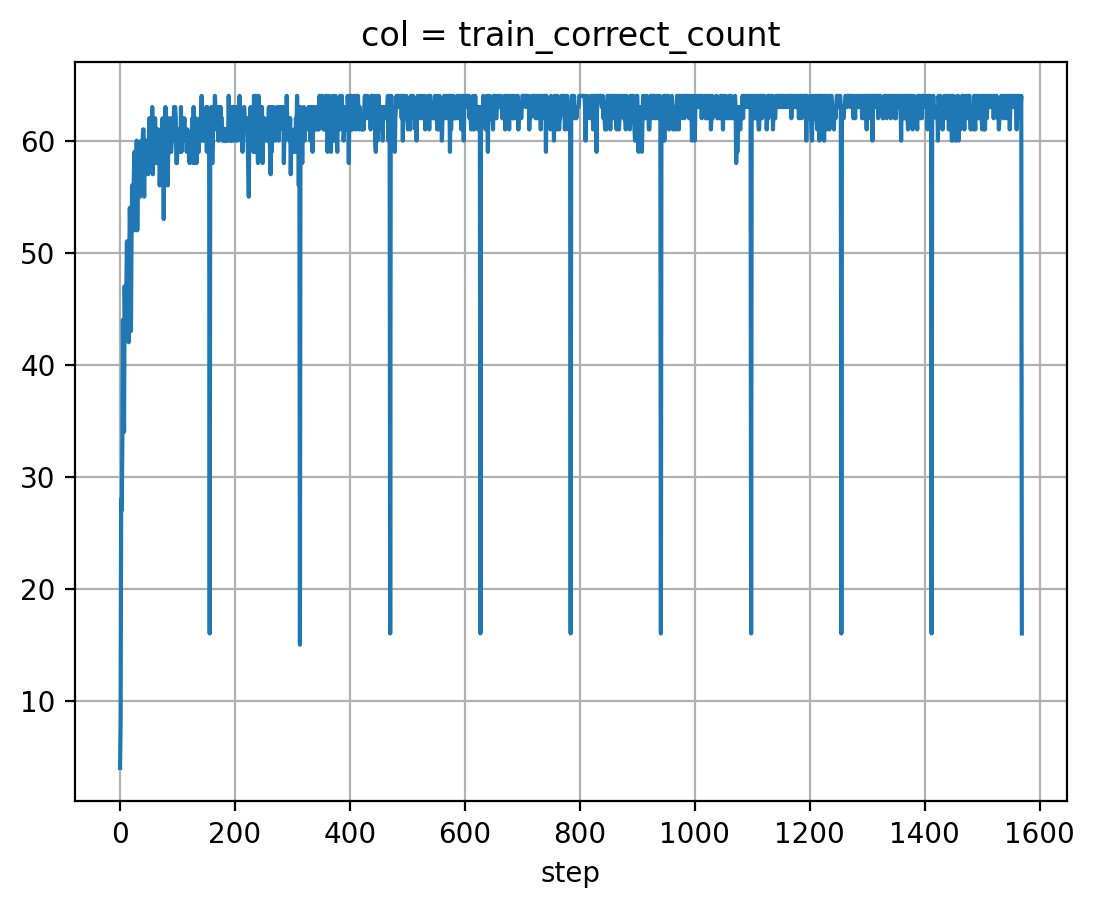

col = train_correct_pct


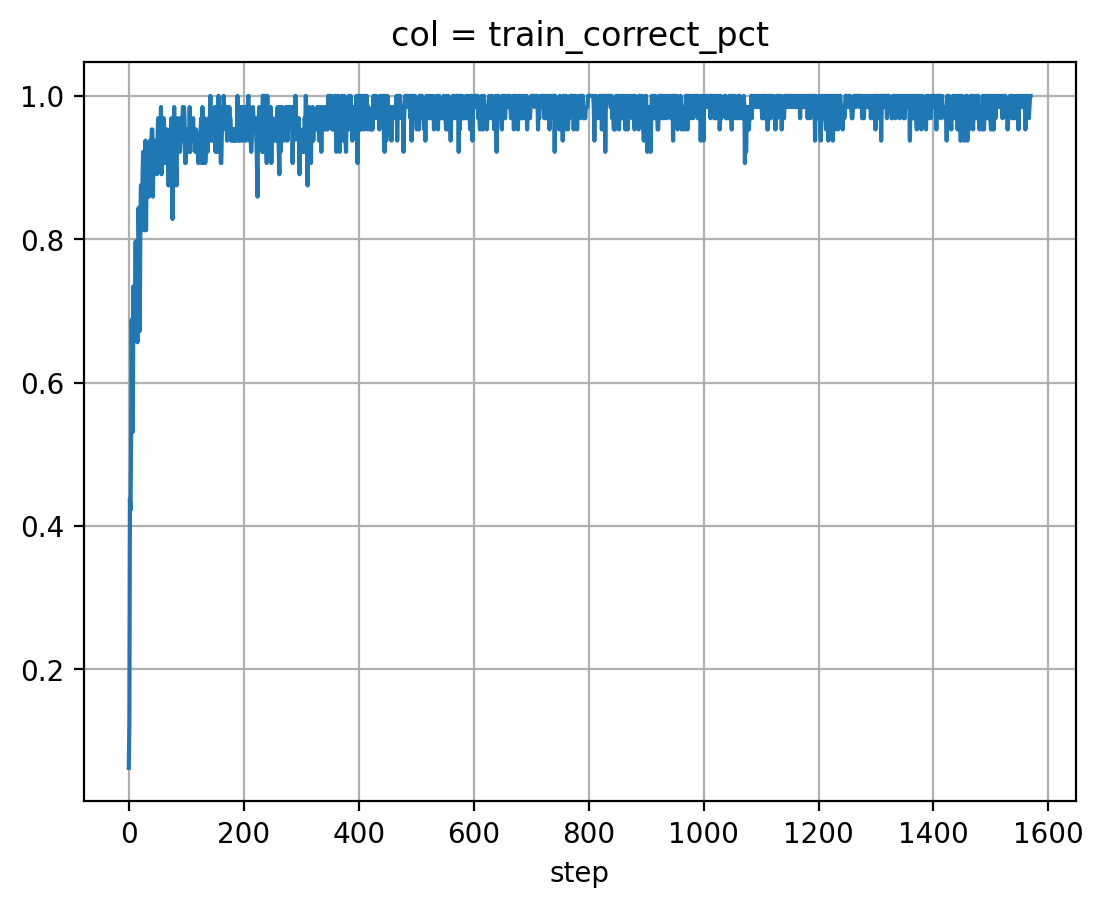

col = eval_loss


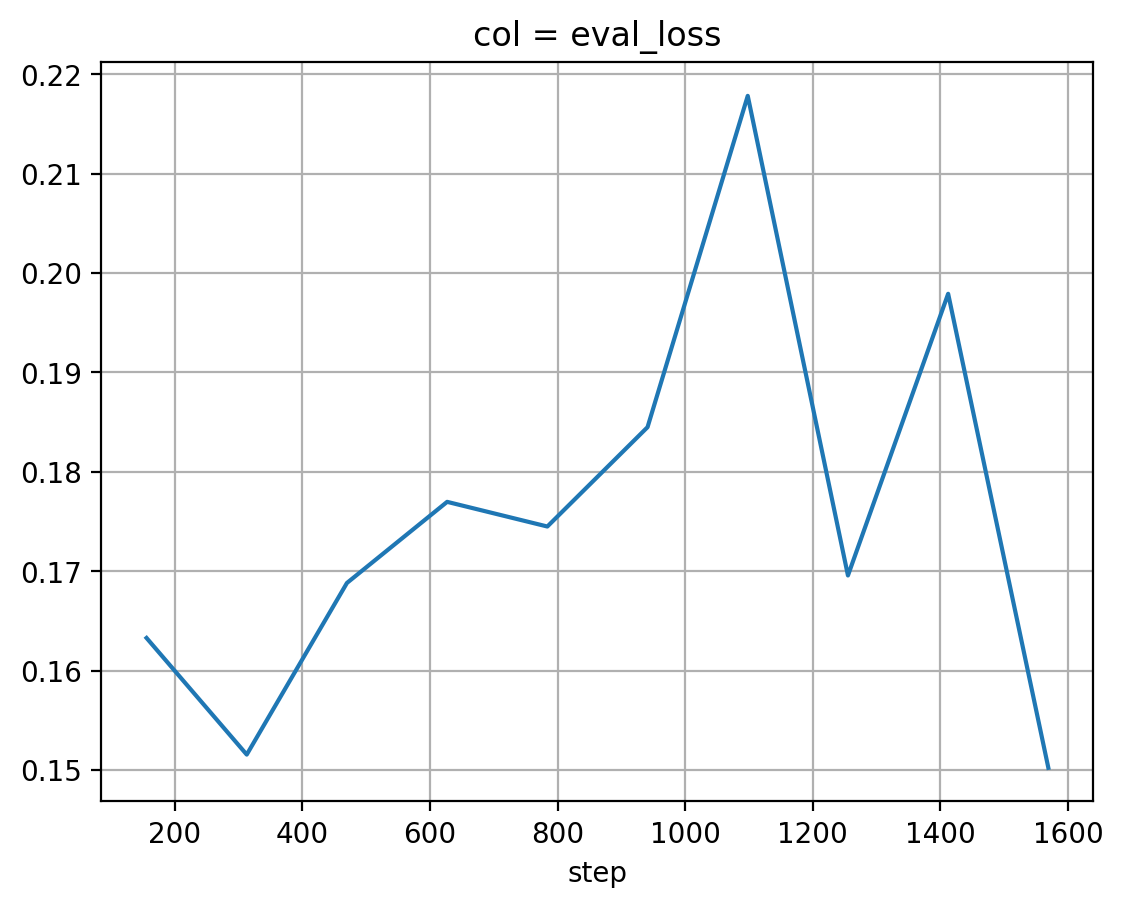

col = eval_correct_predictions_count


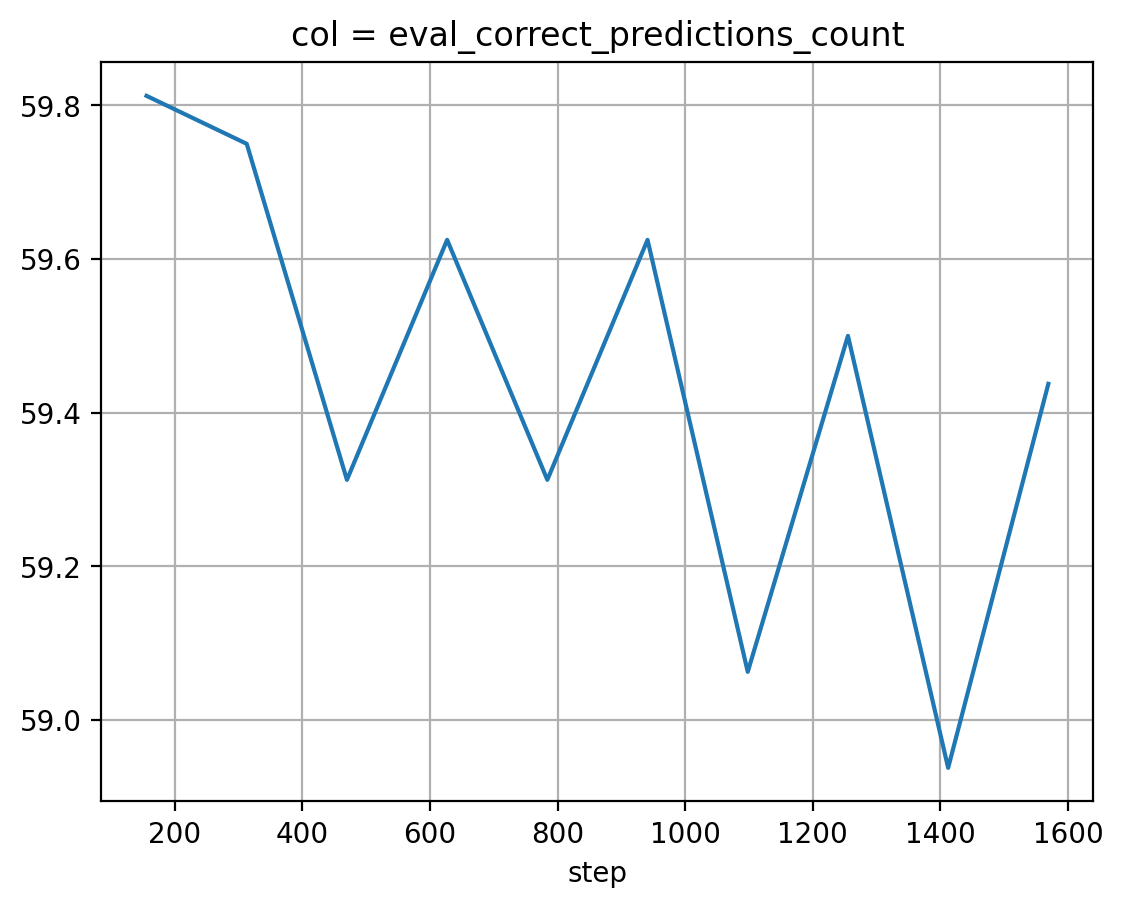

col = eval_correct_pct


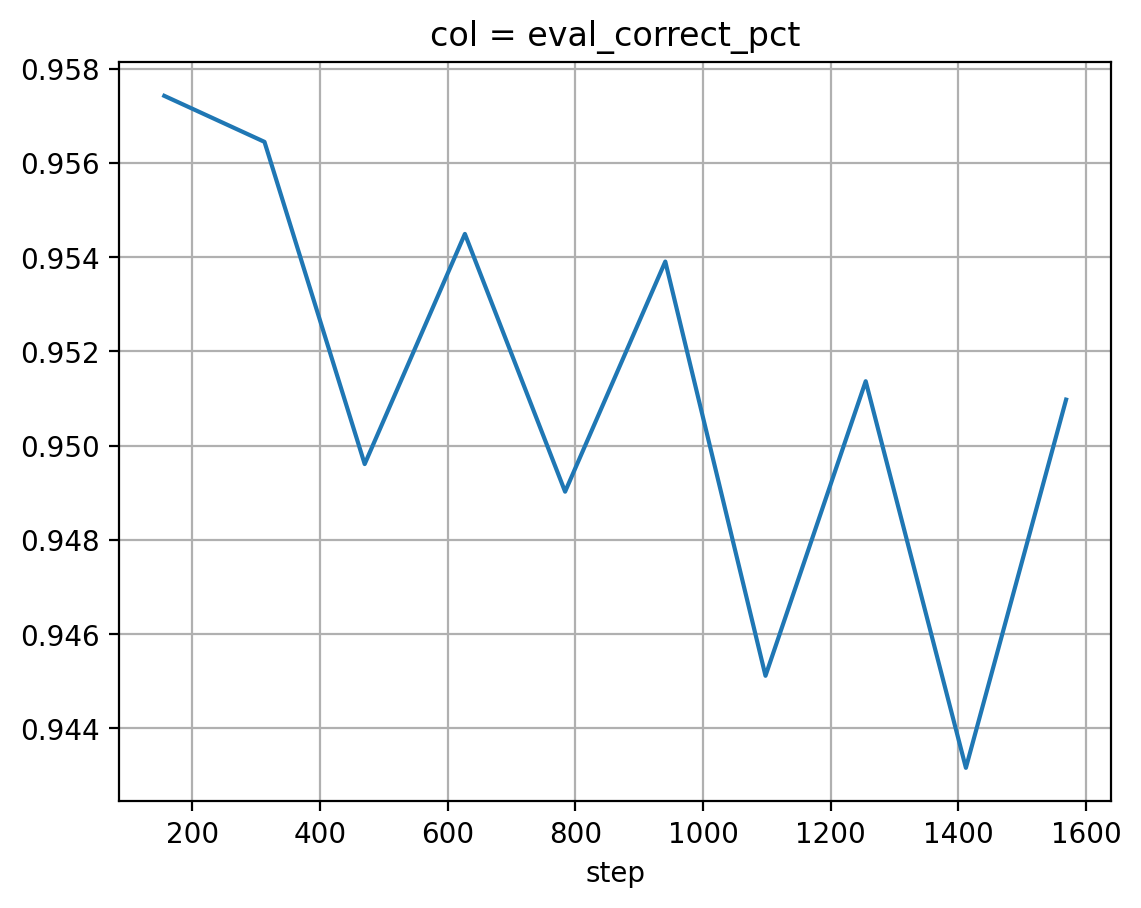

In [ ]:
df_res_2 = load_results('./two_encoder/lightning_logs/version_0/metrics.csv')

Checkpoints with smallets eval loss:

In [ ]:
(10_000 // 64) * 10

1560

In [ ]:
display(df_res_1.loc[df_res_1.eval_loss.sort_values().index[0].item()])
display(df_res_1.loc[df_res_1.eval_loss.sort_values().index[0].item() - 1]))

,train_loss,train_correct_count,train_correct_pct,eval_loss,eval_correct_predictions_count,eval_correct_pct
step,,,,,,
313,NaN,NaN,NaN,0.095543,61.0,0.975977
313,0.005247,16.0,1.0,NaN,NaN,NaN


train_loss                         0.162415
train_correct_count               60.000000
train_correct_pct                  0.937500
eval_loss                               NaN
eval_correct_predictions_count          NaN
eval_correct_pct                        NaN
Name: 312, dtype: float64

In [ ]:
display(df_res_2.loc[df_res_2.eval_loss.sort_values().index[0].item()])
display(df_res_2.loc[df_res_2.eval_loss.sort_values().index[0].item() - 1])

,train_loss,train_correct_count,train_correct_pct,eval_loss,eval_correct_predictions_count,eval_correct_pct
step,,,,,,
1569,NaN,NaN,NaN,0.150212,59.4375,0.950977
1569,0.001347,16.0,1.0,NaN,NaN,NaN


train_loss                         0.010711
train_correct_count               64.000000
train_correct_pct                  1.000000
eval_loss                               NaN
eval_correct_predictions_count          NaN
eval_correct_pct                        NaN
Name: 1568, dtype: float64

In [ ]:
df_res_1.eval_loss.sort_values().index[0]

313

In [ ]:
best_checkpoints = {
    'single_encoder': 'single_encoder/ckpt-312.pt',
    'two_encoder': 'single_encoder/ckpt-1560.pt',
}

In [ ]:
!tree *encoder

single_encoder
├── ckpt-1092.pt
├── ckpt-1248.pt
├── ckpt-1404.pt
├── ckpt-1560.pt
├── ckpt-156.pt
├── ckpt-312.pt
├── ckpt-468.pt
├── ckpt-624.pt
├── ckpt-780.pt
├── ckpt-936.pt
└── lightning_logs
    └── version_0
        └── metrics.csv
two_encoder
├── ckpt-1092.pt
├── ckpt-1248.pt
├── ckpt-1404.pt
├── ckpt-1560.pt
├── ckpt-156.pt
├── ckpt-312.pt
├── ckpt-468.pt
├── ckpt-624.pt
├── ckpt-780.pt
├── ckpt-936.pt
└── lightning_logs
    └── version_0
        └── metrics.csv

4 directories, 22 files


# Indexing and retrieving

## Loading queries

In [ ]:
def convert_queries_to_trec_format(output_file):
    ds = datasets.load_dataset('BeIR/trec-covid', 'queries')['queries']
    ds.to_csv(output_file, header=None, sep='\t', columns=['_id', 'text'])

QUERIES_FILE = 'trec-covid-queries_trec_format.txt'

convert_queries_to_trec_format(QUERIES_FILE)
!wc -l {QUERIES_FILE}
!cat {QUERIES_FILE}

Generating queries split: 0 examples [00:00, ? examples/s]

Dataset trec-covid downloaded and prepared to /root/.cache/huggingface/datasets/BeIR___trec-covid/queries/0.0.0/093f1fe2ffa7a9c72fa48239c8f279b51d6b171abd77737c7fd1406125307599. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

50 trec-covid-queries_trec_format.txt
1	what is the origin of COVID-19
2	how does the coronavirus respond to changes in the weather
3	will SARS-CoV2 infected people develop immunity? Is cross protection possible?
4	what causes death from Covid-19?
5	what drugs have been active against SARS-CoV or SARS-CoV-2 in animal studies?
6	what types of rapid testing for Covid-19 have been developed?
7	are there serological tests that detect antibodies to coronavirus?
8	how has lack of testing availability led to underreporting of true incidence of Covid-19?
9	how has COVID-19 affected Canada
10	has social distancing had an impact on slowing the spread of COVID-19?
11	what are the guidelines for triaging patients infected with coronavirus?
12	what are best practices in hospitals and at home in maintaining quarantine?
13	what are the transmission routes of coronavirus?
14	what evidence is there related to COVID-19 super spreaders
15	how long can the coronavirus live outside the body
16	how long doe

In [ ]:
df_queries = pl.read_csv(QUERIES_FILE, separator='\t', new_columns=['id', 'text'],
                      has_header=False)
len(df_queries), df_queries[:2]

(50,
 shape: (2, 2)
 ┌─────┬────────────────────────────────────────────────────────────┐
 │ id  ┆ text                                                       │
 │ --- ┆ ---                                                        │
 │ i64 ┆ str                                                        │
 ╞═════╪════════════════════════════════════════════════════════════╡
 │ 1   ┆ what is the origin of COVID-19                             │
 │ 2   ┆ how does the coronavirus respond to changes in the weather │
 └─────┴────────────────────────────────────────────────────────────┘)

## Downloading corpus

## Exhaustive Search

In [ ]:
def read_hf_concat_title_text() -> pl.DataFrame:
    ds = datasets.load_dataset('BeIR/trec-covid', 'corpus')['corpus']
    df = pl.from_arrow(ds.data.table)
    df = df.with_columns(
        pl.format('{}. {}', 'title', 'text').alias('title_and_text'))
    df = df.select(pl.col('_id').alias('id'),
                   pl.col('title_and_text').alias('text'))

    return df

df_corpus = read_hf_concat_title_text()
df_corpus.head()

  0%|          | 0/1 [00:00<?, ?it/s]

id,text
str,str
"""ug7v899j""","""Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumonia, 14 (…"
"""02tnwd4m""","""Nitric oxide: a pro-inflammatory mediator in lung disease?. Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the pres…"
"""ejv2xln0""","""Surfactant protein-D and pulmonary host defense. Surfactant protein-D (SP-D) participates in the innate response to inhaled microorganisms and organic antigens, and contributes to immune and inflammatory regulation within the lung. SP-D is synthesized and secreted by alveolar and bronchiolar epithelial cells, but is also expressed by epithelial cells lining various exocrine ducts and the mucosa of the gastrointestinal and genitourinary tracts. SP-D, a collagenous calcium-dependent lectin (or collectin), binds to surface glycoconjugates expressed by a wide variety of microorganisms, and to oligosaccharides associated with the surface of various complex organic antigens. SP-D also specifically interacts with glycoconjugates and other molecules expressed on the surface of macrophages, neutrophils, and lymphocytes. In addition, SP-D binds to specific surfactant-associated lipids and can influence the organization of lipid mixtures containing phosphatidylinositol in vitro. Consistent with …"
"""2b73a28n""","""Role of endothelin-1 in lung disease. Endothelin-1 (ET-1) is a 21 amino acid peptide with diverse biological activity that has been implicated in numerous diseases. ET-1 is a potent mitogen regulator of smooth muscle tone, and inflammatory mediator that may play a key role in diseases of the airways, pulmonary circulation, and inflammatory lung diseases, both acute and chronic. This review will focus on the biology of ET-1 and its role in lung disease."""
"""9785vg6d""","""Gene expression in epithelial cells in response to pneumovirus infection. Respiratory syncytial virus (RSV) and pneumonia virus of mice (PVM) are viruses of the family Paramyxoviridae, subfamily pneumovirus, which cause clinically important respiratory infections in humans and rodents, respectively. The respiratory epithelial target cells respond to viral infection with specific alterations in gene expression, including prod

In [ ]:
import sentence_transformers
from sentence_transformers import SentenceTransformer
from sentence_transformers import util as st_utils

In [ ]:
model = SentenceTransformer

In [ ]:
This model is too slow for the time constraint

### Model: all-MiniLM-L12-v2

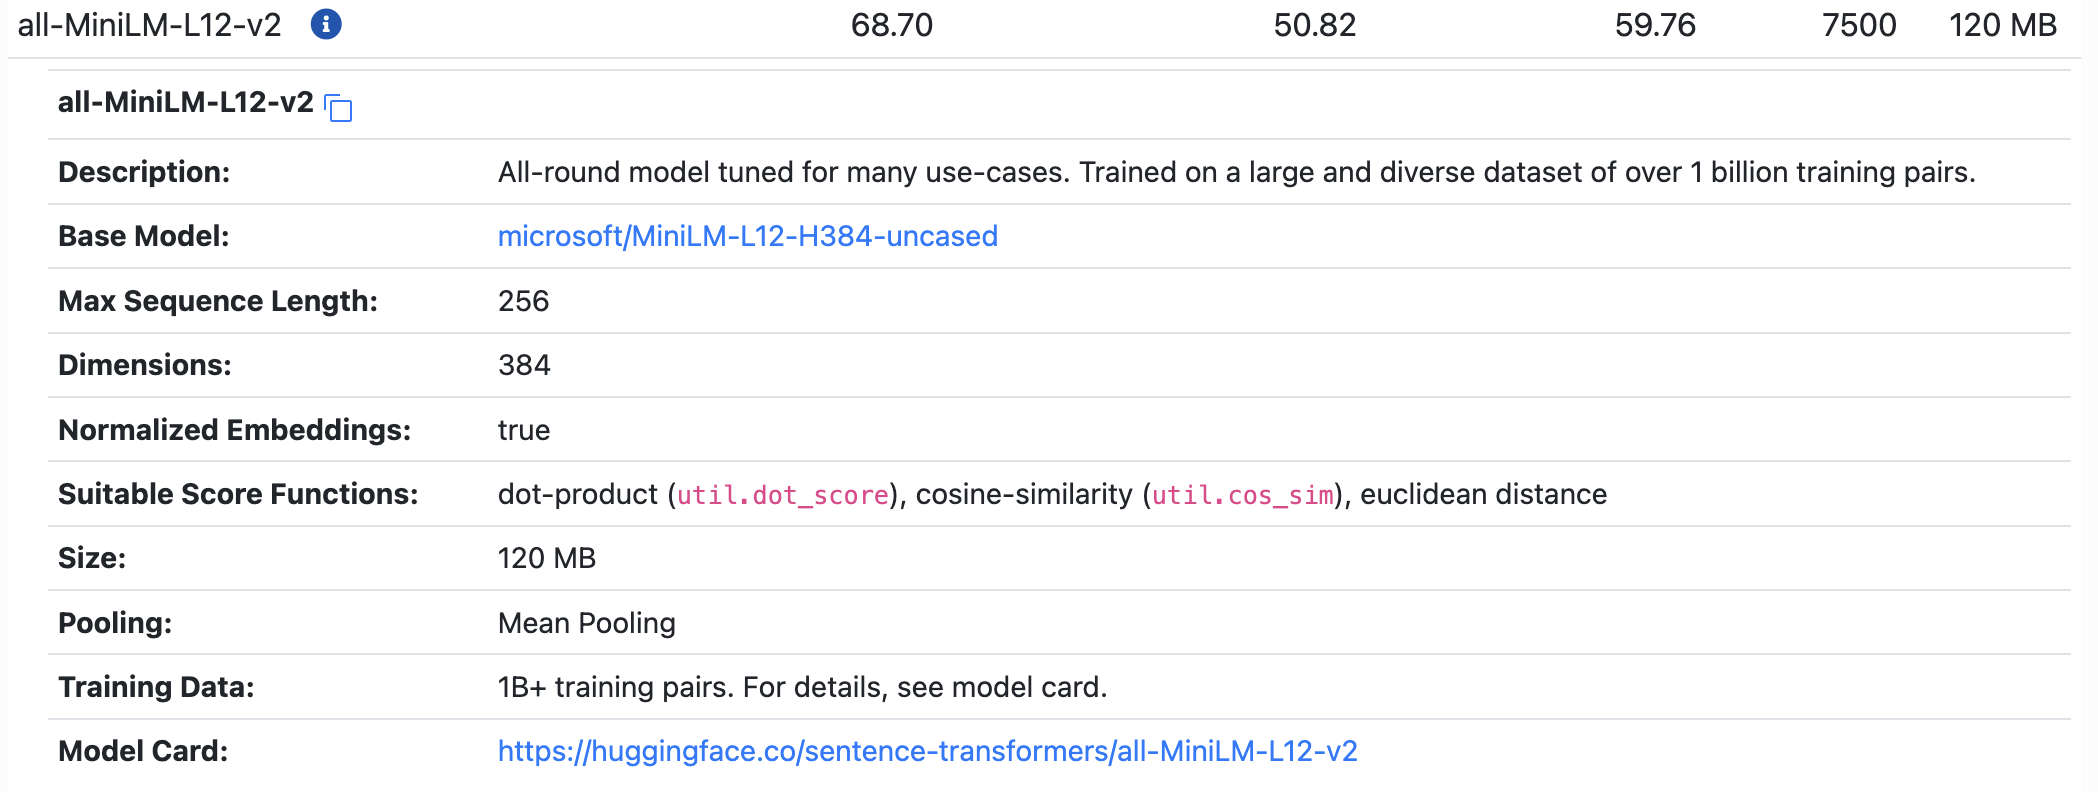

In [ ]:
model = SentenceTransformer('all-MiniLM-L12-v2')

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L12-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda


In [ ]:
del model; torch.cuda.empty_cache(); gc.collect()

12983

In [ ]:
corpus_embeddings = model.encode(df_corpus['text'].to_numpy(), batch_size=256)

Batches:   0%|          | 0/670 [00:00<?, ?it/s]

In [ ]:
query_embeddings = model.encode(df_queries['text'].to_numpy(), batch_size=256)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def save_np_array(np_array, path):
    """Save a numpy array to a file.

    Args:
        np_array: The numpy array to save.
        path: The path to save the numpy array to.
    """
    with open(path, 'wb') as f:
        np.save(f, np_array)

save_np_array(corpus_embeddings, 'all-MiniLM-L12-v2.corpus_embeddings.npy')
save_np_array(query_embeddings, 'all-MiniLM-L12-v2.query_embeddings.npy')
!ls -lht

total 259M
-rw-r--r-- 1 root root 251M Apr 20 05:01 all-MiniLM-L12-v2.corpus_embeddings.npy
-rw-r--r-- 1 root root  76K Apr 20 05:01 all-MiniLM-L12-v2.query_embeddings.npy
-rw-r--r-- 1 root root 3.6K Apr 20 04:15 trec-covid-queries_trec_format.txt
drwxr-xr-x 3 root root 4.0K Apr 20 02:31 single_encoder
drwxr-xr-x 3 root root 4.0K Apr 20 01:55 two_encoder
drwxr-xr-x 1 root root 4.0K Apr 18 22:00 sample_data
-rw-r--r-- 1 root root 7.8M Feb  6 12:05 msmarco_triples.train.tiny.tsv


In [ ]:
top_scores = st_utils.semantic_search(query_embeddings, corpus_embeddings, top_k=1000, score_function=st_utils.cos_sim)
top_scores[0][:10]

[{'corpus_id': 94609, 'score': 0.8642910718917847},
 {'corpus_id': 119952, 'score': 0.8441046476364136},
 {'corpus_id': 144616, 'score': 0.814052402973175},
 {'corpus_id': 93277, 'score': 0.8036707639694214},
 {'corpus_id': 98740, 'score': 0.7918477058410645},
 {'corpus_id': 158966, 'score': 0.786066472530365},
 {'corpus_id': 118215, 'score': 0.7787529230117798},
 {'corpus_id': 153736, 'score': 0.7751889228820801},
 {'corpus_id': 158127, 'score': 0.7751889228820801},
 {'corpus_id': 106021, 'score': 0.7737945318222046}]

In [ ]:
top_scores = st_utils.semantic_search(query_embeddings, corpus_embeddings, top_k=1000, score_function=st_utils.dot_score)
top_scores[0][:10]

[{'corpus_id': 94609, 'score': 0.8642910718917847},
 {'corpus_id': 119952, 'score': 0.8441046476364136},
 {'corpus_id': 144616, 'score': 0.8140523433685303},
 {'corpus_id': 93277, 'score': 0.8036707043647766},
 {'corpus_id': 98740, 'score': 0.7918477058410645},
 {'corpus_id': 158966, 'score': 0.786066472530365},
 {'corpus_id': 118215, 'score': 0.7787529230117798},
 {'corpus_id': 153736, 'score': 0.7751889228820801},
 {'corpus_id': 158127, 'score': 0.7751889228820801},
 {'corpus_id': 106021, 'score': 0.7737945318222046}]

In [ ]:
corpus_embeddings

array([[ 0.02580151, -0.04204772, -0.0924621 , ..., -0.06547933,
        -0.03801836,  0.05797018],
       [-0.04027713, -0.03133734, -0.033923  , ..., -0.02425295,
         0.03982881,  0.03051318],
       [-0.0489321 , -0.03785968,  0.01422001, ...,  0.04185516,
         0.09923478,  0.08632717],
       ...,
       [-0.00209064, -0.05730132, -0.07923233, ...,  0.11564906,
        -0.04362607, -0.02097536],
       [ 0.02920361,  0.00970624, -0.07623315, ..., -0.02542238,
         0.04038238, -0.02743509],
       [ 0.00958314, -0.01995182, -0.04598527, ...,  0.0218229 ,
         0.01608375, -0.04133906]], dtype=float32)

In [ ]:
def search(model, tokenizer, queries, corpus, batch_size, pooler_fn):
    # we have a small number of queries, so we will load them all at once
    query_embeddings =

In [ ]:
sentence_transformers.util.semantic_search

<function sentence_transformers.util.semantic_search(query_embeddings: torch.Tensor, corpus_embeddings: torch.Tensor, query_chunk_size: int = 100, corpus_chunk_size: int = 500000, top_k: int = 10, score_function: Callable[[torch.Tensor, torch.Tensor], torch.Tensor] = <function cos_sim at 0x7f66f38e58b0>)>

In [ ]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

In [ ]:
relevant_docs = (
    datasets.load_dataset('BeIR/trec-covid-qrels')['test'].to_pandas()
    .groupby(['query-id'])['corpus-id'].agg(set).to_dict())
print(toolz.valmap(len, relevant_docs))

  0%|          | 0/1 [00:00<?, ?it/s]

{1: 1565, 2: 1251, 3: 1649, 4: 1793, 5: 1643, 6: 1562, 7: 1331, 8: 1837, 9: 1606, 10: 1100, 11: 1745, 12: 1573, 13: 1822, 14: 1262, 15: 1941, 16: 1600, 17: 1298, 18: 1267, 19: 1449, 20: 1177, 21: 1571, 22: 1270, 23: 1245, 24: 1194, 25: 1536, 26: 1657, 27: 1421, 28: 1032, 29: 1188, 30: 991, 31: 1656, 32: 1540, 33: 1221, 34: 1768, 35: 1316, 36: 1147, 37: 1144, 38: 1795, 39: 1135, 40: 1172, 41: 972, 42: 707, 43: 801, 44: 1139, 45: 1067, 46: 631, 47: 979, 48: 696, 49: 1036, 50: 838}


In [ ]:
evaluator = InformationRetrievalEvaluator(
    queries=dict(zip(df_queries['id'], df_queries['text'])),
    corpus=dict(zip(df_corpus['id'], df_corpus['text'])),
    relevant_docs=relevant_docs,
    batch_size=256,
    show_progress_bar=True,
    precision_recall_at_k=[1_000]
)

In [ ]:
evaluator(model)

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Information Retrieval Evaluation on  dataset:


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Corpus Chunks: 100%|██████████| 4/4 [05:26<00:00, 81.58s/it]
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Queries: 50
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Corpus: 171332

INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Score-Function: cos_sim
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@1: 74.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@3: 84.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@5: 92.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Accuracy@10: 98.00%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Precision@1000: 21.60%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:Recall@1000: 18.01%
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:MRR@10: 0.8100
INFO:sentence_transformers.evaluation.InformationRetrievalEvaluator:NDCG

0.32790065114335026

In [ ]:
Busca exaustiva (com evaluator do sentence transformers):
- 'all-MiniLM-L12-v2': cos_sim -> NDCG@10: 0.6667
- 'all-MiniLM-L12-v2': dot_score -> NDCG@10: 0.6667

In [ ]:
del model; torch.cuda.empty_cache(); gc.collect()

0

## Our model: single encoder

In [ ]:
def load_model(path):
    """Load DPR model into SentenceTransformer model for evaluation"""
    def get_new_sentence_transformer(max_length):
        transformer_model = sentence_transformers.models.Transformer(
            'microsoft/MiniLM-L12-H384-uncased', max_seq_length=max_length)
        pooler = sentence_transformers.models.Pooling(
            word_embedding_dimension=transformer.get_word_embedding_dimension(),
            pooling_mode_mean_tokens=True)
        return Snetn


    placeholder_encoder = AutoModel.from_pretrained(
        'microsoft/MiniLM-L12-H384-uncased')
    dpr = DPR(placeholder_encoder, placeholder_encoder)
    state_dict = torch.load(path)['model']

    dpr.load_state_dict(state_dict)
    dpr.eval()
    dpr.to('cuda')
    return dpr

In [ ]:
def load_model(path):
    """Load DPR model into SentenceTransformer model for evaluation"""
    def get_model(name):

    placeholder_encoder = AutoModel.from_pretrained(
        'microsoft/MiniLM-L12-H384-uncased')
    dpr = DPR(placeholder_encoder, placeholder_encoder)
    state_dict = torch.load(path)['model']

    dpr.load_state_dict(state_dict)
    dpr.eval()
    dpr.to('cuda')
    return dpr

In [ ]:
dpr = load_model(best_checkpoints['single_encoder'])

In [ ]:
dpr

Transformer({'max_seq_length': 32, 'do_lower_case': False}) with Transformer model: BertModel 

In [ ]:

sentence_transformers.models.Transformer(AutoModel.from_pretrained(
        'microsoft/MiniLM-L12-H384-uncased'), max_seq_length=32)

OSError: ignored

In [ ]:
dpr = sentence_transformers.models.Transformer('microsoft/MiniLM-L12-H384-uncased', max_seq_length=32)

In [ ]:
SentenceTransformer(modules=[transformer, pooler])

In [ ]:
a = SentenceTransformer(modules=[sentence_transformers.models.Transformer('microsoft/MiniLM-L12-H384-uncased', max_seq_length=32), ])

INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda


In [ ]:
next(a.named_modules())

('',
 SentenceTransformer(
   (0): Transformer({'max_seq_length': 32, 'do_lower_case': False}) with Transformer model: BertModel 
 ))